In this section, we will train the ViT model with
- learning rate = 0.0001
- cosine learning rate scheduler with warmup
- using the preprocessed image dataset whereby the hair noises are removed
- data augmentation (random horizontal filp, zoom, rotation, cropping)
- balanced class weight
- dropout with a probability of 0.5 (0.2, 0.3, 0.4, 0.5)

The trained model is pushed to the
[hugging face hub](https://huggingface.co/sharren/vit-dropout-0.5/tree/main)



*Early stopping is employed: stop training if there is no improvement in the evaluation metric (in this case, decrease in validation loss) for 10 evaluation steps.*

# Dependencies and Libraries

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Installation

In [ ]:
#!pip install transformers
!pip install accelerate -U
# !pip install transformers[torch]
!pip install datasets
!pip install tensorboard
# !pip install wandb
#!pip install huggingface_hub

In [ ]:
# install transformer from source
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-voe20ivq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-voe20ivq
  Resolved https://github.com/huggingface/transformers.git to commit ff841900e45763114d2417fb24ce29d950c6c956
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Import

In [ ]:
import pandas as pd
from google.colab import userdata
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import v2
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import notebook_login
from tqdm.notebook import tqdm
# import wandb

# Load Dataset from Huggingface

In [ ]:
skin_dataset = load_dataset("sharren/processedSkin")

In [ ]:
skin_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5128
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2884
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2003
    })
})

In [ ]:
labels = skin_dataset["train"].features["label"].names

idx2label = {idx: label for idx, label in enumerate(labels)}
label2idx = {label: idx for idx, label in enumerate(labels)}

In [ ]:
label2idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# Processor


In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')

# Transformation (With augmentation)

- flips horizontally with a probability of 0.5
- rotates the input image by a maximum angle of 10 degrees
- zooms into or out of the input image by a factor sampled uniformly from the range [1-0.1, 1+0.1]
- resizes the input image to a larger size, and then randomly crops a region of size 224x224 from the resized image

In [ ]:
# to apply what's in the default image processor along with the augmentation
image_mean, image_std = processor.image_mean, processor.image_std
normalize = v2.Normalize(mean=image_mean, std=image_std)

In [ ]:
from torchvision import transforms as v2
train_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomZoom(0.1),
    v2.RandomResizedCrop(224),
    v2.ToTensor(),
    normalize
])

In [ ]:
test_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Set the transforms
skin_dataset['train'].set_transform(train_transforms)
skin_dataset['validation'].set_transform(test_transforms)
skin_dataset['test'].set_transform(test_transforms)

# Functions for Trainer

## Collate Function

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


## Compute Metrics Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(labels, predictions, average='weighted',zero_division=0)
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



A warning occur when training
`UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples`.
This warning commonly occurs in multi-class classification problems when some classes are not predicted by the model. It's often caused by class imbalance or the model's inability to adequately learn certain classes.



> To address this warning for the current stage, zero_division parameter is set in precision_score to specify the behavior when a class has no predicted samples.  Use a numeric value (in this case, 0) to use as the precision when the denominator is zero.




To further address the root cause which is class imbalance issue, we will use data augmentation in the later stage.

## Feature Extractor

In [ ]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Model

In [ ]:
model_id = 'google/vit-base-patch16-224'

In [ ]:
import os
import shutil
import pandas as pd

os.chdir('/content/drive/MyDrive/FYP/data')

skin_df = pd.read_csv('HAM10000_metadata.csv')
df_labels = skin_df[['image_id', 'dx']].rename(columns={'dx': 'label'})
df_labels.head()

,image_id,label
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [ ]:
# Unmount Google Drive
from google.colab import drive
drive.flush_and_unmount()

# Change directory to default Colab directory
import os
os.chdir('/content')

# Verify current directory
print("Current directory:", os.getcwd())

Current directory: /content


In [ ]:
from transformers import ViTForImageClassification, ViTConfig

# Initialize a ViT base configuration
configuration = ViTConfig()

# No dropout initially
# Set dropout probabilities (adjust as needed)

configuration.attention_probs_dropout_prob = 0.5 #(0.2,0.3,0.4,0.5) defaults to 0.1

# Set classification head
# configuration.num_labels=len(labels)
configuration.id2label={str(i): c for i, c in enumerate(labels)}
configuration.label2id={c: str(i) for i, c in enumerate(labels)}
# Instantiate the model with the custom configuration and classification head
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    config=configuration,
    ignore_mismatched_sizes=True,)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainer

## Arguments

In [ ]:
epochs=100

Since early-stopping is employed, the total training steps calculated using the epochs may not be suitable, the total training steps will be extracted from the previous experiment using cosine scheduler which is 3852 (12 epochs)

In [ ]:
total_training_steps = 	6099 #from class weight expt / 7062 * 0.05 (from dropout0.3)
warmup_steps = int(total_training_steps * 0.2) #0.05-0.2

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
  output_dir="./vit-dropout-0.5",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="epoch",
  num_train_epochs=epochs,
  fp16=True,
  learning_rate= 0.0001,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  metric_for_best_model="eval_loss", # early stopping criteria
  greater_is_better=False,
  lr_scheduler_type='cosine',
  warmup_steps=warmup_steps,
  lr_scheduler_kwargs={'num_cycles': 2},
)

## Custom Trainer: Loss function


**Loss Function**

For consistency among models, the compute_loss is overidden so that it is similar to CategoricalCrossentropy in Tensorflow

*EfficientNet and ResNet will be trained with Tensorflow framework*

## **Class Weight**

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
                                                  y=df_labels["label"])

In [ ]:
class_weights

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

In [ ]:
loss_fct.weight

tensor([ 4.3753,  2.7835,  1.3018, 12.4410,  1.2855,  0.2134, 10.0755],
       dtype=torch.float64)

In [ ]:
# Convert class weights to a tensor with the correct data type (Float)
# this is required to avoid error : expected scalar type Float but found Double
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# for class weight
import torch
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor ).to('cuda')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Apply Early Stopping



 The training will stop if there is no improvement in the evaluation metric (in this case, validation loss) for 10 evaluation steps.

In [ ]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=skin_dataset['train'],
    eval_dataset=skin_dataset['validation'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(10, 0.0)],
    # lr_scheduler=ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    # optimizers=(optimizer, trainer.create_scheduler(total_training_steps)),
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


# Fine-tuning
We can now finetune our model by just calling the train method:

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.664200,0.859698,0.717753,0.689838,0.717753,0.675335
2,1.119100,0.628559,0.765603,0.767781,0.765603,0.765336
3,1.074100,0.677059,0.754508,0.779535,0.754508,0.735261
4,1.002300,0.626923,0.770804,0.783948,0.770804,0.772676
5,0.920000,0.601000,0.781553,0.791276,0.781553,0.781094
6,0.915500,0.539896,0.794383,0.803484,0.794383,0.797886
7,0.797100,0.701616,0.734743,0.790350,0.734743,0.750854
8,0.717100,0.635197,0.739598,0.817500,0.739598,0.760138
9,0.676000,0.507308,0.807212,0.824124,0.807212,0.811957
10,0.631200,0.555207,0.785021,0.837357,0.785021,0.797820


***** train metrics *****
  epoch                    =         27.0
  total_flos               = 9992822751GF
  train_loss               =       0.5048
  train_runtime            =   0:53:59.43
  train_samples_per_second =      158.299
  train_steps_per_second   =        9.909


*The train metrics are saved as train_results.json (assesible in the hub)*

# Evaluation on validation set

A good learning rate
-  leads to improved performance metrics such as accuracy, precision, recall, or F1-score on the validation set.

- promotes stable training, exihibiting a smooth decrease in loss over time

- results in a decreasing training loss without significant overfitting (validation loss remains low)

In [ ]:
metrics = trainer.evaluate(skin_dataset['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       27.0
  eval_accuracy           =     0.8592
  eval_f1                 =     0.8581
  eval_loss               =     0.4899
  eval_precision          =     0.8593
  eval_recall             =     0.8592
  eval_runtime            = 0:00:23.42
  eval_samples_per_second =     123.11
  eval_steps_per_second   =      15.41


In [ ]:
print(trainer.state)

TrainerState(epoch=27.0, global_step=8667, max_steps=32100, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=16, num_train_epochs=100, num_input_tokens_seen=0, total_flos=1.0729711727592948e+19, log_history=[{'loss': 1.6642, 'grad_norm': 27.312969207763672, 'learning_rate': 2.6004922067268256e-05, 'epoch': 1.0, 'step': 321}, {'eval_loss': 0.8596980571746826, 'eval_accuracy': 0.717753120665742, 'eval_precision': 0.6898380965198315, 'eval_recall': 0.717753120665742, 'eval_f1': 0.6753350772702824, 'eval_runtime': 23.6334, 'eval_samples_per_second': 122.031, 'eval_steps_per_second': 15.275, 'epoch': 1.0, 'step': 321}, {'loss': 1.1191, 'grad_norm': 19.919342041015625, 'learning_rate': 5.233798195242002e-05, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.6285594701766968, 'eval_accuracy': 0.7656033287101248, 'eval_precision': 0.7677806381392357, 'eval_recall': 0.7656033287101248, 'eval_f1': 0.7653357947346289, 'eval_runtime': 23.5137, 'eval_samples_per_second': 122.652, 'eval

In [ ]:
print(trainer.state.log_history)

[{'loss': 1.6642, 'grad_norm': 27.312969207763672, 'learning_rate': 2.6004922067268256e-05, 'epoch': 1.0, 'step': 321}, {'eval_loss': 0.8596980571746826, 'eval_accuracy': 0.717753120665742, 'eval_precision': 0.6898380965198315, 'eval_recall': 0.717753120665742, 'eval_f1': 0.6753350772702824, 'eval_runtime': 23.6334, 'eval_samples_per_second': 122.031, 'eval_steps_per_second': 15.275, 'epoch': 1.0, 'step': 321}, {'loss': 1.1191, 'grad_norm': 19.919342041015625, 'learning_rate': 5.233798195242002e-05, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.6285594701766968, 'eval_accuracy': 0.7656033287101248, 'eval_precision': 0.7677806381392357, 'eval_recall': 0.7656033287101248, 'eval_f1': 0.7653357947346289, 'eval_runtime': 23.5137, 'eval_samples_per_second': 122.652, 'eval_steps_per_second': 15.353, 'epoch': 2.0, 'step': 642}, {'loss': 1.0741, 'grad_norm': 10.239236831665039, 'learning_rate': 7.867104183757178e-05, 'epoch': 3.0, 'step': 963}, {'eval_loss': 0.6770591139793396, 'eval_accuracy': 0

In [ ]:
loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        loss.append(elem['loss'])
print(loss)

[1.6642, 1.1191, 1.0741, 1.0023, 0.92, 0.9155, 0.7971, 0.7171, 0.676, 0.6312, 0.5777, 0.4686, 0.4134, 0.3904, 0.3388, 0.301, 0.2516, 0.2433, 0.1769, 0.179, 0.1401, 0.1085, 0.1188, 0.106, 0.1029, 0.0761, 0.1207]


In [ ]:
print("Length of loss:", len(loss))

Length of loss: 27


In [ ]:
eval_loss = []
for elem in trainer.state.log_history:
    if 'eval_loss' in elem.keys():
        eval_loss.append(elem['eval_loss'])

eval_loss = eval_loss[:-1]
print(eval_loss)

[0.8596980571746826, 0.6285594701766968, 0.6770591139793396, 0.626923143863678, 0.6009995341300964, 0.5398955941200256, 0.7016158103942871, 0.6351965665817261, 0.5073079466819763, 0.5552068948745728, 0.517503023147583, 0.5712271332740784, 0.6331254243850708, 0.6161268949508667, 0.5141295790672302, 0.5525261163711548, 0.4898887276649475, 0.5183467268943787, 0.6016170978546143, 0.6330150961875916, 0.5883798003196716, 0.6131150722503662, 0.6343638896942139, 0.615183413028717, 0.6209478378295898, 0.6190057396888733, 0.6154376864433289]


In [ ]:
print("Length of eval_loss:", len(eval_loss))

Length of eval_loss: 27


### Loss curve



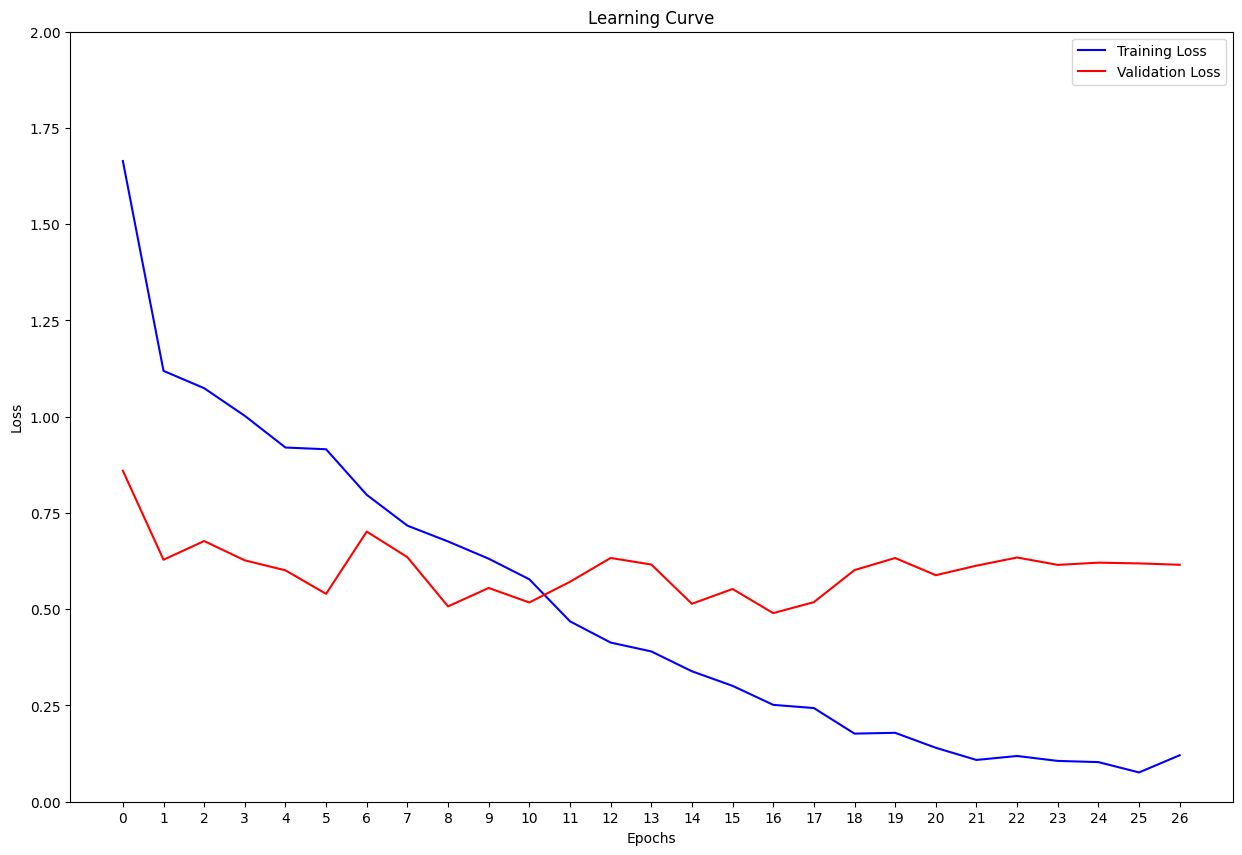

In [ ]:
import matplotlib.pyplot as plt

x_values = range(0, int(trainer.state.epoch), 1)
plt.figure(figsize=(15, 10))
plt.plot(x_values, loss, 'b-', label='Training Loss')
plt.plot(x_values, eval_loss, 'r-', label='Validation Loss')
plt.ylim(0,2)

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, int(trainer.state.epoch), 1))
plt.legend()

plt.show()


Below is the learning curve after class weighting

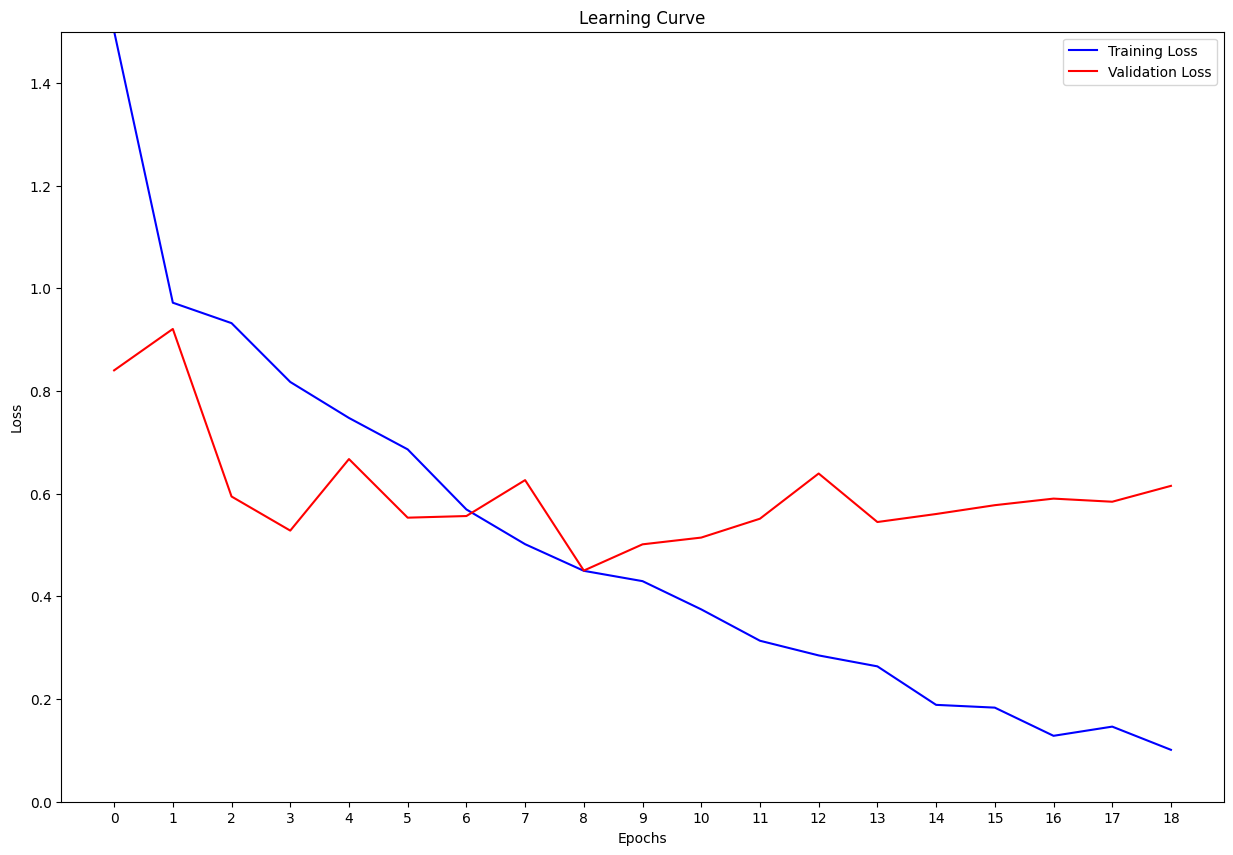

## Tensorboard

From the tensorboard, it shows the plots for training loss over steps,validation loss over steps, validation accuracy, gradient norms.

A stable/converging model should show:
- Smooth decrease in loss over time, sudden jumps may indicate instability
- Increasing accuracy
- Gradual decrease in gradient norms (indicate convergence)


[Access Tensorboard](https://huggingface.co/sharren/vit-dropout-0.5/tensorboard)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir vit-dropout-0.5/runs/Mar21_12-00-23_45242e0ea5c0

# Performance on Test Set

In [ ]:
outputs = trainer.predict(skin_dataset['test'])

In [ ]:
print(outputs.metrics)

{'test_loss': 0.5078004002571106, 'test_accuracy': 0.8622066899650525, 'test_precision': 0.8626294478912738, 'test_recall': 0.8622066899650525, 'test_f1': 0.8614516035282164, 'test_runtime': 17.31, 'test_samples_per_second': 115.714, 'test_steps_per_second': 14.5}


Comparing test performance of the current model using preprocessed dataset vs model using original dataset

In [ ]:
import pandas as pd

# Define the dictionaries containing the metrics
metrics_before = {
    'Metric': ['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test Runtime', 'Test Samples/Second', 'Test Steps/Second'],
    'Value': [0.47369253635406494, 0.8462306540189716, 0.8444153070390849,
                 0.8462306540189716, 0.8439597684023159, 16.7601, 119.51, 14.976]
}

metrics_after = {
    'Metric': ['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test Runtime', 'Test Samples/Second', 'Test Steps/Second'],
    'Value': [outputs.metrics['test_loss'], outputs.metrics['test_accuracy'], outputs.metrics['test_precision'],
              outputs.metrics['test_recall'], outputs.metrics['test_f1'], outputs.metrics['test_runtime'],
              outputs.metrics['test_samples_per_second'], outputs.metrics['test_steps_per_second']]
}

# Create pandas DataFrames
df_1 = pd.DataFrame(metrics_before)
df_2 = pd.DataFrame(metrics_after)

# Set Metric column as index for both DataFrames
df_1.set_index('Metric', inplace=True)
df_2.set_index('Metric', inplace=True)

# Concatenate DataFrames horizontally
df_combined = pd.concat([df_1, df_2], axis=1, keys=['Before', 'After'])

# Display the combined DataFrame
print(df_combined)


                         Before       After
                          Value       Value
Metric                                     
Test Loss              0.473693    0.507800
Test Accuracy          0.846231    0.862207
Test Precision         0.844415    0.862629
Test Recall            0.846231    0.862207
Test F1                0.843960    0.861452
Test Runtime          16.760100   17.310000
Test Samples/Second  119.510000  115.714000
Test Steps/Second     14.976000   14.500000


Comparable test performance

# Push model to hub

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'skin-cancer',
    "tags": ['image-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1711025729.45242e0ea5c0.20273.17:   0%|          | 0.00/560 [00:00<?, ?B/s]